# Load the data

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./german.data', header=None, sep=' ')
features = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']

df.columns = features
df.head()

,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### For ML model data need to be preprocessed.
We have to represent categorical data somehow for the ML model. For this, I decided to create a column for each category value and give it value 1 or 0. It allows using Random Forest or Linear Regression algorithm efficiently.

In [3]:
targets = df['classification']
df = df.drop(columns=['classification']);
targets = [0 if target == 2 else 1 for target in targets]

In [4]:
def extCheck(value):
    if (value == 'A11'):
        return 1
    elif (value == 'A12'):
        return 2
    elif (value == 'A13'):
        return 3
    elif (value == 'A14'):
        return 0

def preprocess2(data):
    X = data.copy()
    X['existingchecking'] = X['existingchecking'].apply(extCheck)
    categorial_features = []
    for c in X:
        first_v = X[c][0]
        if (type(first_v) is str and len(first_v) <= 4 and first_v[0] == 'A'):
            categorial_features.append(c)
    
    categorial_values = {}
    for c in categorial_features:
        for v in X[c]:
            if v not in categorial_values:
                categorial_values[v] = True
    
    for cv in categorial_values:
        X[cv] = pd.Series(np.zeros(len(X)))
    
    for i, data in X.iterrows():
        for c in categorial_features:
            X.loc[i, data[c]] = 1
    X = X.drop(columns=categorial_features)
    return X

In [5]:
X = preprocess2(df)

In [6]:
X = X.rename(columns={
    'A91': 'male/divorced',
    'A92': 'female/married',
    'A93': 'male/single',
    'A94': 'male/married',
    'A95': 'female/single',
}, index=str)

# Random Forest model

Split dataset into train and test samples

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.1, random_state=42)

In [8]:
import sklearn.ensemble
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=42)

In [9]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [10]:
preds = rf.predict(X_test)
sklearn.metrics.f1_score(y_test, preds, average='binary')

0.8571428571428571

Accurancy of the model

# SHAP example of model features

Import library

In [11]:
import shap

In [12]:
shap.initjs()

In [35]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[0], shap_values[0], X)

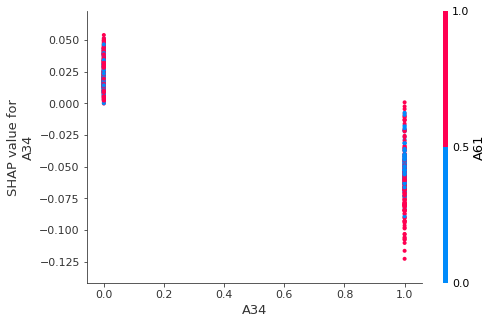

In [33]:
shap.dependence_plot("A34", shap_values[0], X)

Given plot shows dependence of selected feature, its impact on final result

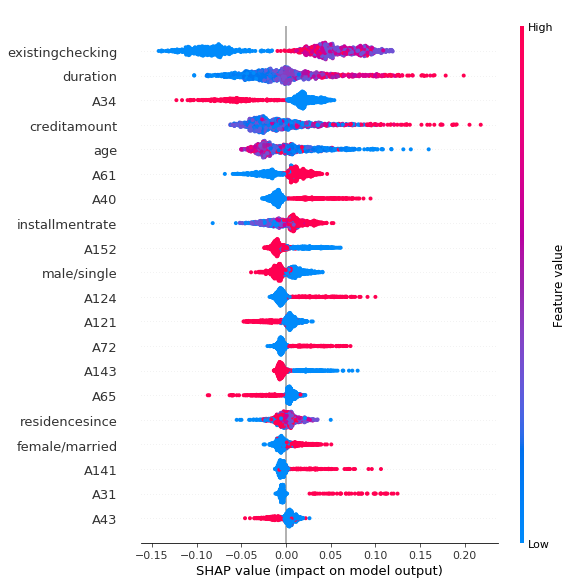

In [38]:
shap.summary_plot(shap_values[0], X)

As we can observe on this plot we have different value for our features 

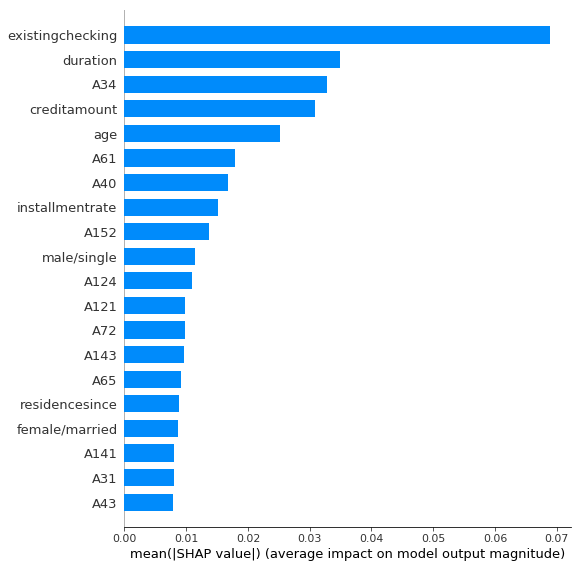

In [39]:
shap.summary_plot(shap_values[0], X, plot_type="bar")


A34 : critical account/ other credits existing (not at this bank) 